## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2022-06-08 11:49:09--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.09s   

2022-06-08 11:49:09 (141 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [2]:
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 12.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x39e20000 @  0x7f426b226615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does n

In [3]:
! pip  install subword-nmt
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import sys
# в папке NLP находятся 3 файла utils, my_network_1, my_network_2
sys.path.insert(0,'/content/gdrive/My Drive/NLP')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.legacy.datasets import TranslationDataset, Multi30k

import spacy

import random
import math
import time
import numpy as np
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [7]:
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Первая модель. Используется: RNN, Attention (по исходному предложению)

### Main part (my_network_1)
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Length distribution in Train data


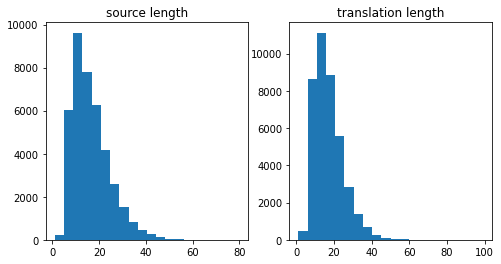

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


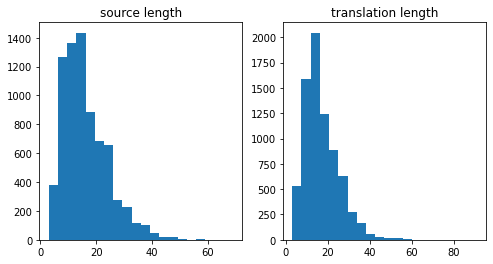

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side (my_network_1)
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [ ]:
import my_network_1


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = my_network_1.Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = my_network_1.Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = my_network_1.Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = my_network_1.Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

model.apply(my_network_1.init_weights)


print(f'The model has {my_network_1.count_parameters(model):,} trainable parameters')

The model has 30,856,101 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

####Используется RNN, Attention (Метод `forward` принимает ввод `mask`. Это тензор, в котором 1, если токен исходного предложения не является токеном заполнения, и 0, если он является токеном заполнения. Например, если исходное предложение: ["привет", "как", "ты", "?", `<pad>`, `<pad>`], то маска будет [1 , 1, 1, 1, 0, 0])

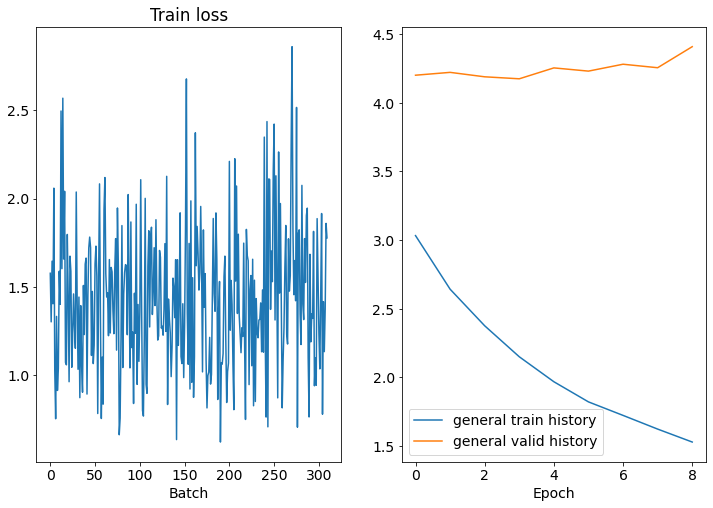

Epoch: 10 | Time: 2m 28s
	Train Loss: 1.437 | Train PPL:   4.209
	 Val. Loss: 4.508 |  Val. PPL:  90.770


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = my_network_1.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = my_network_1.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = my_network_1.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model.load_state_dict(torch.load('model_1.pt'))

test_loss = my_network_1.evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.154 | Test PPL:  63.670 |


In [ ]:
#пример из train_data
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['железнодорожная', 'станция', 'ендынпо', 'находится', 'в', '400', 'метрах', 'от', 'отеля', '.']
trg = ['yeongdeungpo', 'station', 'is', '400', 'metres', 'away', '.']


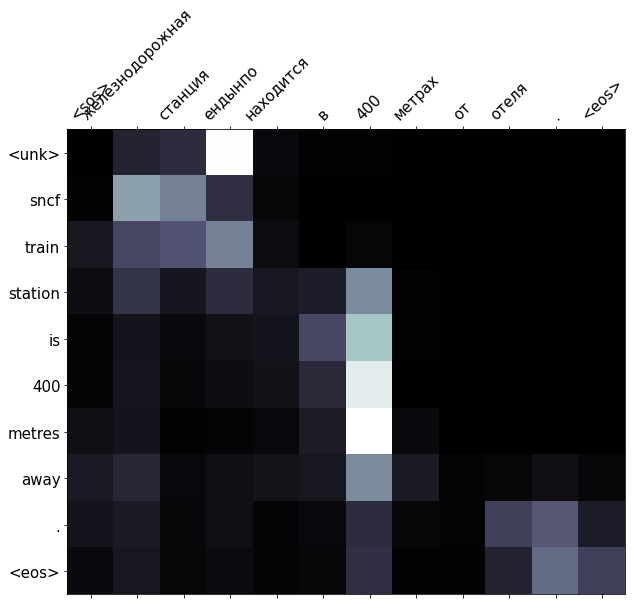

predicted trg = ['<unk>', 'sncf', 'train', 'station', 'is', '400', 'metres', 'away', '.', '<eos>']


In [ ]:
translation, attention = my_network_1.translate_sentence(src, SRC, TRG, model, device)

my_network_1.display_attention(src, translation, attention)

print(f'predicted trg = {translation}')

In [ ]:
#пример из valid_data

example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['в', 'вашем', 'распоряжении', 'недавно', 'построенная', 'общая', 'мини', '-', 'кухня', 'с', 'холодильником', ',', 'микроволновой', 'печью', 'и', 'электрическим', 'чайником', '.']
trg = ['the', 'newly', 'built', 'common', 'kitchenette', 'includes', 'a', 'fridge', ',', 'microwave', 'and', 'electric', 'kettle', '.']


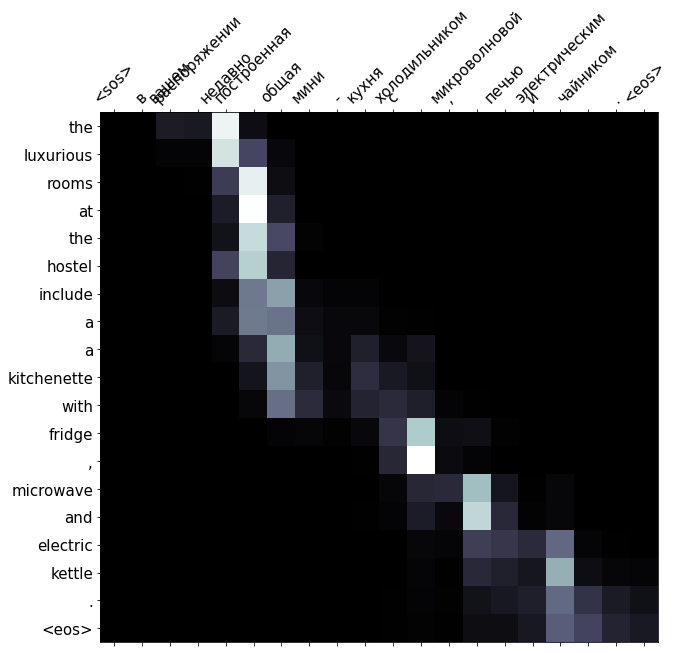

predicted trg = ['the', 'luxurious', 'rooms', 'at', 'the', 'hostel', 'include', 'a', 'a', 'kitchenette', 'with', 'fridge', ',', 'microwave', 'and', 'electric', 'kettle', '.', '<eos>']


In [ ]:
translation, attention = my_network_1.translate_sentence(src, SRC, TRG, model, device)

my_network_1.display_attention(src, translation, attention)

print(f'predicted trg = {translation}')

In [ ]:
bleu_score = my_network_1.calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 27.40


Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

## Вторая модель. Используется BERT, Attention (self-attention)

### Main part (my_network_2)
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [8]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())


SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [11]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [12]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14170
Unique tokens in target (en) vocabulary: 10149


Here are tokens from original (RU) corpus:

In [13]:
SRC.vocab.itos[::1000]

['<unk>',
 'palace',
 'tower',
 'пекарня',
 'bungalow',
 '+',
 'marbella',
 'хиккадувы',
 'жак',
 'травами',
 'mary',
 'варнемюнде',
 'лагеря',
 'проекта',
 'чистой']

And from target (EN) corpus:

In [14]:
TRG.vocab.itos[::1000]

['<unk>',
 'mare',
 'external',
 'cambridge',
 'nantes',
 'skala',
 'mazatlán',
 'beginning',
 'hart',
 'penkenbahn',
 'véu']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['there', 'is', 'also', 'a', '24', '/', '7', 'convenience', 'store', '.'], 'src': ['кроме', 'того', ',', 'в', 'отеле', 'работает', 'магазин', 'товаров', 'первой', 'необходимости', '.']}


Let's check the length distributions:

Length distribution in Train data


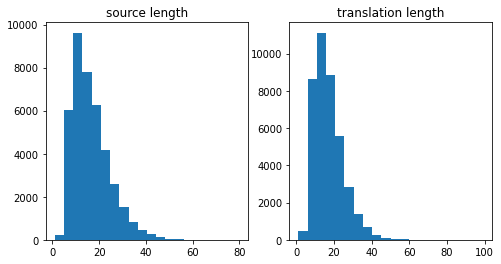

In [16]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


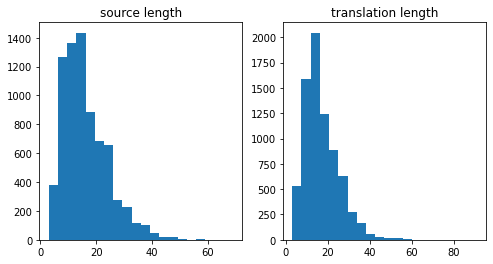

In [17]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side (my_network_2)
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [21]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 128x43 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 128x41 (GPU 0)]
torch.Size([128, 41]) torch.Size([128, 43])


In [22]:
import my_network_2

Encoder = my_network_2.Encoder
Decoder = my_network_2.Decoder
Seq2Seq = my_network_2.Seq2Seq

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256#HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device, False, 100)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device, False, 100)

# dont forget to put the model to the right device

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [24]:
model.apply(my_network_2.init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(14170, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=Fal

In [25]:
print(f'The model has {my_network_2.count_parameters(model):,} trainable parameters')

The model has 11,469,733 trainable parameters


In [26]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

####Используется BERT, Attention (self-attention)

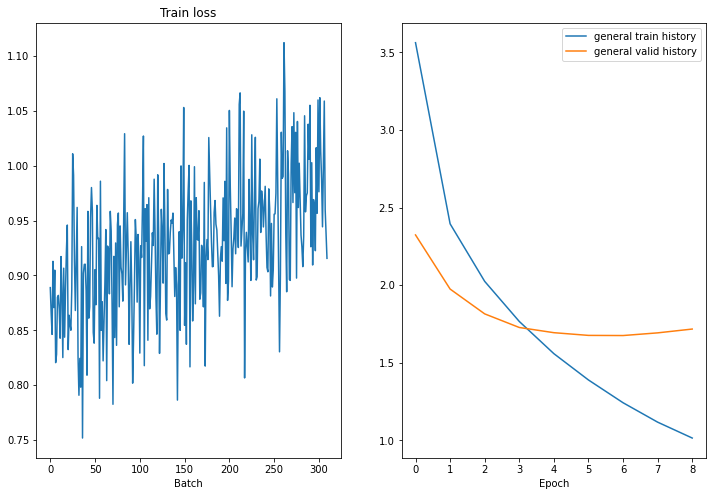

Epoch: 10 | Time: 0m 40s
	Train Loss: 0.928 | Train PPL:   2.530
	 Val. Loss: 1.748 |  Val. PPL:   5.743


In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):    
    start_time = time.time()
    train_loss = my_network_2.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = my_network_2.evaluate(model, valid_iterator, criterion)    
    end_time = time.time()    
    epoch_mins, epoch_secs = my_network_2.epoch_time(start_time, end_time)    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [28]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [29]:
batch = next(iter(test_iterator))

In [30]:
for idx in [1, 2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there a you the the you there free there you the rooms you you the the guests free there the guests a you guests you all a there some breakfast there you other you we free you a you all the shuttle parking bed rooms you some breakfast free you evening all there free the guests daily free it the all there you you a guests they there guest the on guests parking you free you there guests there there extras free you tuapse laundry the free you there the bed free the the a bed towels bathrobes ironing an bed it bed towels the private extras the guests the free on the the there free free the the the bed bed a extras towels towels
Generated: in 24 guests guests 24 24 to 24 24 24 cosy 24 24 in guests on nearby access guests access nice 24 on on apartments guests 24 some every on 24 facilities 24 opposite by 24 24 24 all apartment through on guests all 24 some for to 24 in rooms 24 and guests on housekeeping to has in all 24 in 24 guests access floors 24 in caravan request operates ac

In [31]:
#пример из train_data
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ванная', 'комната', 'оборудована', 'душем', '.']
trg = ['the', 'bathroom', 'includes', 'a', 'shower', '.']


In [32]:
translation, attention = my_network_2.translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'bathroom', 'comes', 'with', 'a', 'shower', '.', '<eos>']


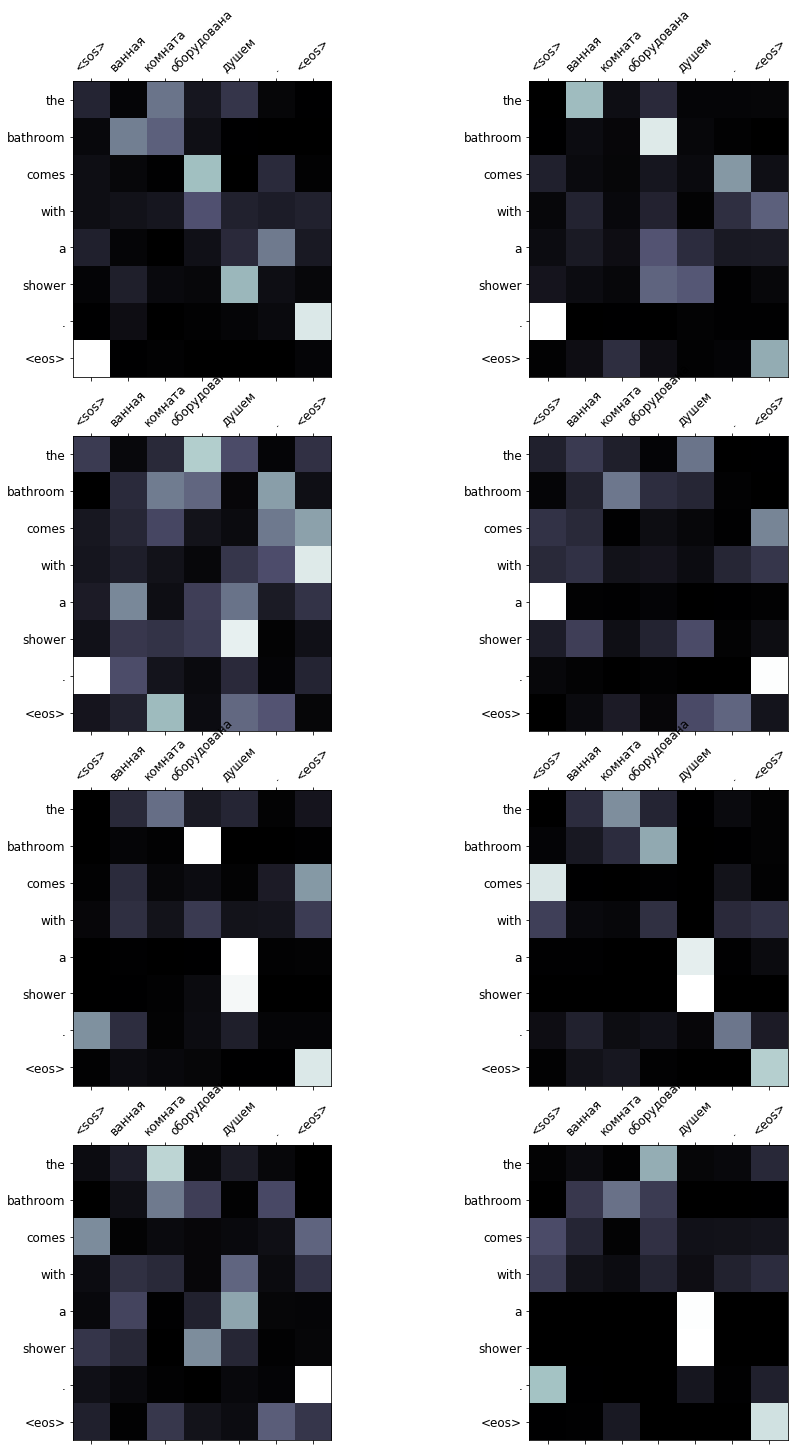

In [33]:
my_network_2.display_attention(src, translation, attention)

In [34]:
#пример из test_data
example_idx = 4

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['стойка', 'регистрации', 'работает', 'круглосуточно', '.', 'осуществляется', 'доставка', 'еды', 'и', 'напитков', 'в', 'номер', '.', 'к', 'услугам', 'гостей', 'камера', 'хранения', 'багажа', 'и', 'пункт', 'обмена', 'валюты', '.']
trg = ['the', 'reception', 'is', 'available', '24', 'hours', 'a', 'day', ',', 'provides', 'room', 'service', ',', 'luggage', 'storage', 'and', 'currency', 'exchange', '.']


In [35]:
translation, attention = my_network_2.translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['there', 'is', 'a', '24', '-', 'hour', 'front', 'desk', 'and', 'room', 'service', 'is', 'available', '.', '<eos>']


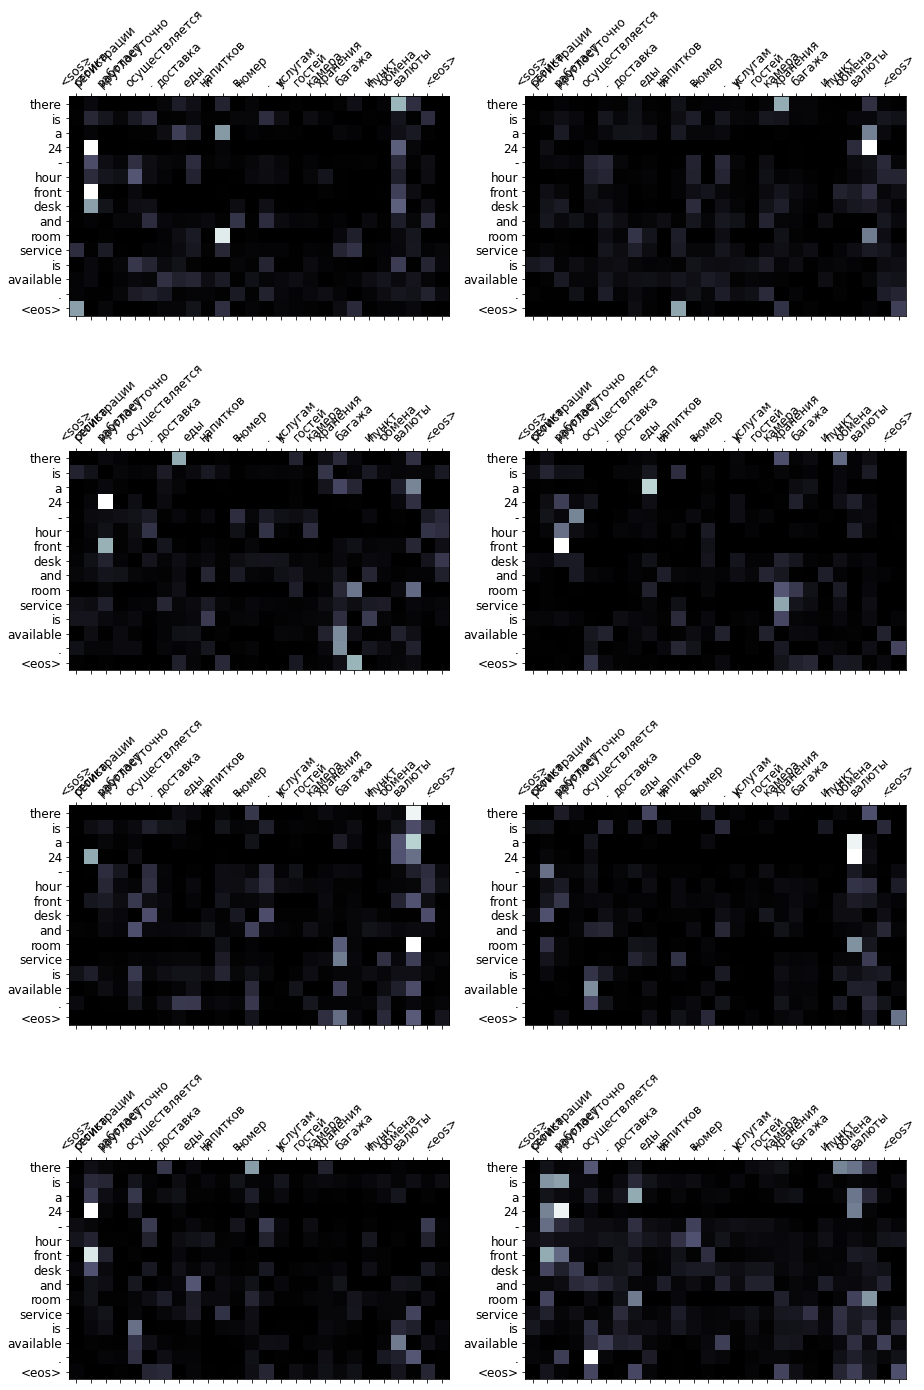

In [36]:
my_network_2.display_attention(src, translation, attention)

In [37]:
model.load_state_dict(torch.load('model_2.pt'))

test_loss = my_network_2.evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.680 | Test PPL:   5.368 |


In [38]:
bleu_score = my_network_2.calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 26.24


Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

## Третья модель. Используется BERT, Attention (self-attention), Positional encoding

### Main part (my_network_2)
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [39]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())


SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [40]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [41]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [42]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [43]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14170
Unique tokens in target (en) vocabulary: 10149


Here are tokens from original (RU) corpus:

In [44]:
SRC.vocab.itos[::1000]

['<unk>',
 'palace',
 'tower',
 'пекарня',
 'bungalow',
 '+',
 'marbella',
 'хиккадувы',
 'жак',
 'травами',
 'mary',
 'варнемюнде',
 'лагеря',
 'проекта',
 'чистой']

And from target (EN) corpus:

In [45]:
TRG.vocab.itos[::1000]

['<unk>',
 'mare',
 'external',
 'cambridge',
 'nantes',
 'skala',
 'mazatlán',
 'beginning',
 'hart',
 'penkenbahn',
 'véu']

And here is example from train dataset:

In [46]:
print(vars(train_data.examples[9]))

{'trg': ['there', 'is', 'also', 'a', '24', '/', '7', 'convenience', 'store', '.'], 'src': ['кроме', 'того', ',', 'в', 'отеле', 'работает', 'магазин', 'товаров', 'первой', 'необходимости', '.']}


Let's check the length distributions:

Length distribution in Train data


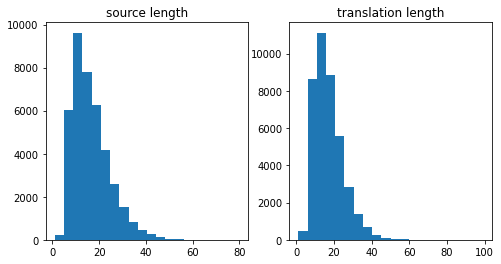

In [47]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


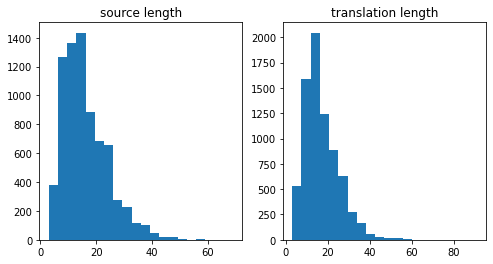

In [48]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side (my_network_2)
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
device

device(type='cuda')

In [51]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [52]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 128x43 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 128x41 (GPU 0)]
torch.Size([128, 41]) torch.Size([128, 43])


In [53]:
import my_network_2

Encoder = my_network_2.Encoder
Decoder = my_network_2.Decoder
Seq2Seq = my_network_2.Seq2Seq

In [54]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256#HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device, True, 100)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device, True, 100)

# dont forget to put the model to the right device

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [55]:
model.apply(my_network_2.init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(14170, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=Fal

In [56]:
print(f'The model has {my_network_2.count_parameters(model):,} trainable parameters')

The model has 11,520,933 trainable parameters


In [57]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

####Используется BERT, Attention (self-attention), Positional encoding

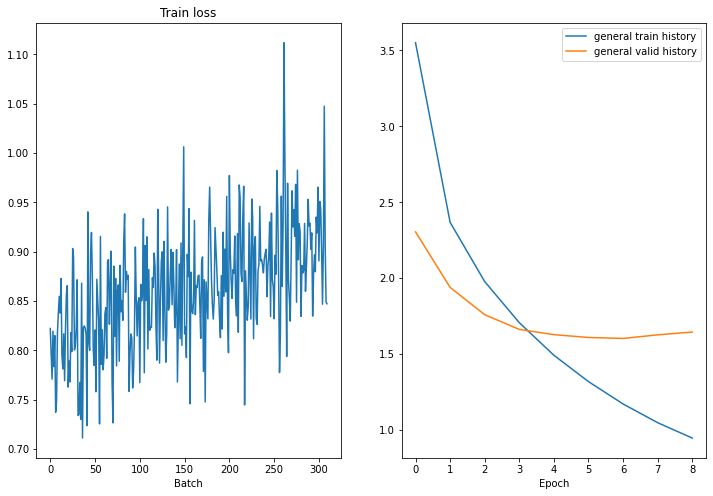

Epoch: 10 | Time: 0m 41s
	Train Loss: 0.862 | Train PPL:   2.367
	 Val. Loss: 1.682 |  Val. PPL:   5.375


In [58]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):    
    start_time = time.time()
    train_loss = my_network_2.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = my_network_2.evaluate(model, valid_iterator, criterion)    
    end_time = time.time()    
    epoch_mins, epoch_secs = my_network_2.epoch_time(start_time, end_time)    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_3.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [59]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [60]:
batch = next(iter(test_iterator))

In [61]:
for idx in [1, 2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there a you the the you there free there you the rooms you you the the guests free there the guests a you guests you all a there some breakfast there you other you we free you a you all the shuttle parking bed rooms you some breakfast free you evening all there free the guests daily free it the all there you you a guests they there guest the on guests parking you free you there guests there there extras free you tuapse laundry the free you there the bed free the the a bed towels bathrobes ironing an bed it bed towels the private extras the guests the free on the the there free free the the the bed bed a extras towels towels
Generated: set 24 guests guests 24 24 access 24 24 front cosy 24 24 in guests on nearby of guests use can 24 on on apartments guests 24 some every on 24 services 24 opposite to 24 24 24 all apartment on on guests all 24 some for access 24 evening air 24 wi guests on cleaning access offers in all 24 in 24 guests use have 24 in includes request 24 use guests

In [62]:
#пример из train_data
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ванная', 'комната', 'оборудована', 'душем', '.']
trg = ['the', 'bathroom', 'includes', 'a', 'shower', '.']


In [63]:
translation, attention = my_network_2.translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'bathroom', 'comes', 'with', 'a', 'shower', '.', '<eos>']


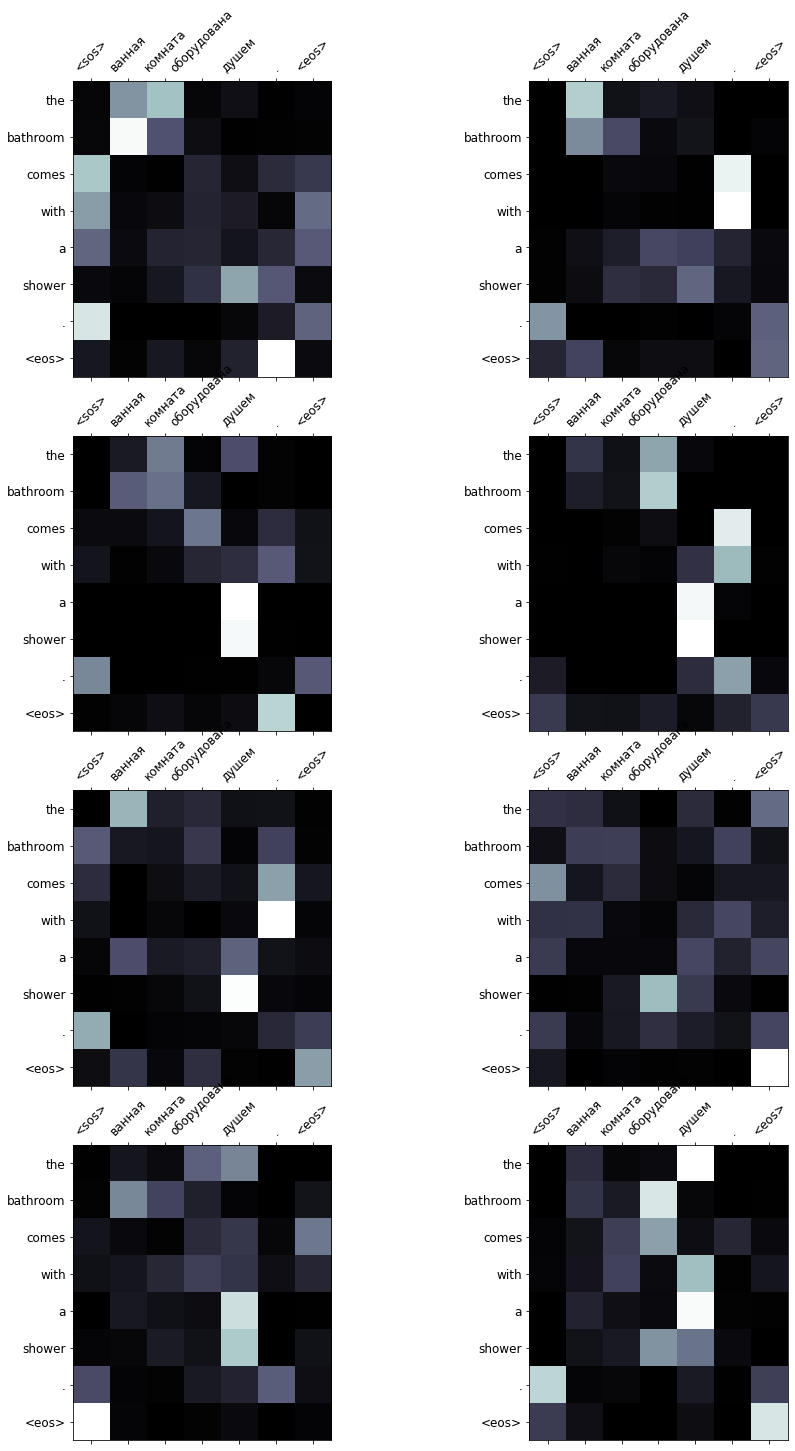

In [64]:
my_network_2.display_attention(src, translation, attention)

In [65]:
#пример из test_data
example_idx = 4

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['стойка', 'регистрации', 'работает', 'круглосуточно', '.', 'осуществляется', 'доставка', 'еды', 'и', 'напитков', 'в', 'номер', '.', 'к', 'услугам', 'гостей', 'камера', 'хранения', 'багажа', 'и', 'пункт', 'обмена', 'валюты', '.']
trg = ['the', 'reception', 'is', 'available', '24', 'hours', 'a', 'day', ',', 'provides', 'room', 'service', ',', 'luggage', 'storage', 'and', 'currency', 'exchange', '.']


In [66]:
translation, attention = my_network_2.translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'front', 'desk', 'provides', '24', '-', 'hour', 'room', 'service', 'and', 'luggage', 'storage', 'service', '.', '<eos>']


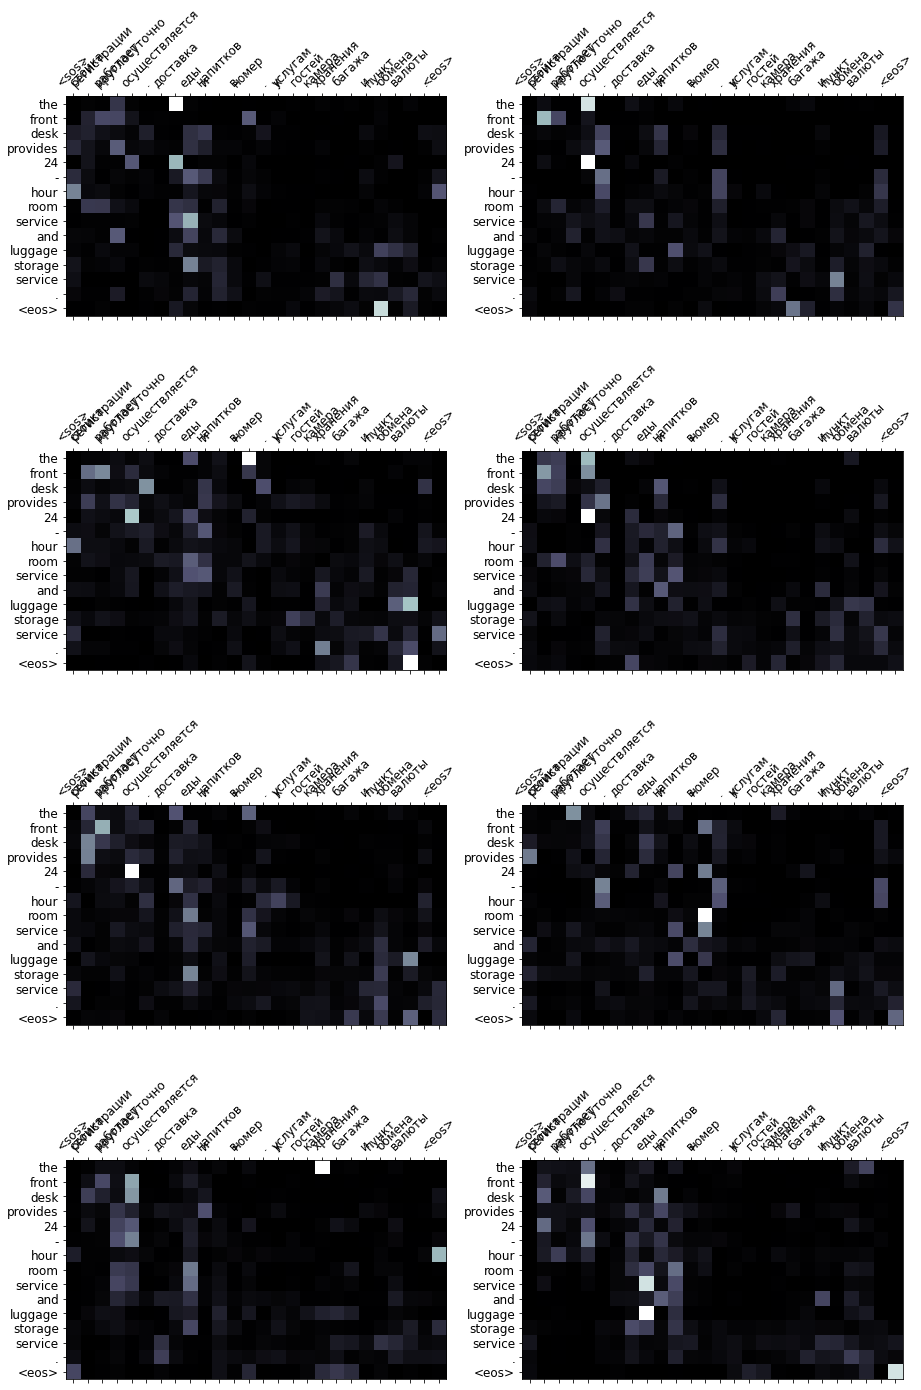

In [67]:
my_network_2.display_attention(src, translation, attention)

In [68]:
model.load_state_dict(torch.load('model_3.pt'))

test_loss = my_network_2.evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.616 | Test PPL:   5.032 |


In [69]:
bleu_score = my_network_2.calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.45


Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

# Вывод: 
## 1 модель: BLEU score = 27.40, время обучения 1 эпохи 2m 28s
## 2 модель: BLEU score = 26.24, время обучения 1 эпохи 0m 40s
## 3 модель: BLEU score = 28.45, время обучения 1 эпохи 0m 41s
## Третья модель по совокупности качества и времени лучше